### Análisis mediante Ridge

In [11]:
import pandas as pd
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configurar MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("regresion_ridge")

2025/05/30 00:38:07 INFO mlflow.tracking.fluent: Experiment with name 'regresion_ridge' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/916738605820158483', creation_time=1748576287230, experiment_id='916738605820158483', last_update_time=1748576287230, lifecycle_stage='active', name='regresion_ridge', tags={}>

In [3]:
# Cargar dataset
df = pd.read_csv(
    "https://raw.githubusercontent.com/dodobeatle/dataeng-datos/refs/heads/main/ToyotaCorolla.csv",
    encoding="utf8",
    engine="python"
)
pd.set_option('display.max_columns', None)

df.head()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Automatic,cc,Doors,Cylinders,Gears,Quarterly_Tax,Weight,Mfr_Guarantee,BOVAG_Guarantee,Guarantee_Period,ABS,Airbag_1,Airbag_2,Airco,Automatic_airco,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Tow_Bar
0,1,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13500,23,10,2002,46986,Diesel,90,1,0,2000,3,4,5,210,1165,0,1,3,1,1,1,0,0,1,0,1,1,1,0,0,0,1,0,0,0
1,2,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13750,23,10,2002,72937,Diesel,90,1,0,2000,3,4,5,210,1165,0,1,3,1,1,1,1,0,1,1,1,0,1,0,0,0,1,0,0,0
2,3,?TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,13950,24,9,2002,41711,Diesel,90,1,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
3,4,TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors,14950,26,7,2002,48000,Diesel,90,0,0,2000,3,4,5,210,1165,1,1,3,1,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,5,TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors,13750,30,3,2002,38500,Diesel,90,0,0,2000,3,4,5,210,1170,1,1,3,1,1,1,1,0,1,0,1,1,1,0,1,0,1,0,0,0


In [4]:
# Calcular nueva edad y eliminar columnas redundantes
df["Age_08_04_calculado"] = (2004 - df["Mfg_Year"]) * 12 + (8 - df["Mfg_Month"])
df.drop(columns=["Mfg_Year", "Mfg_Month", "Age_08_04"], inplace=True)

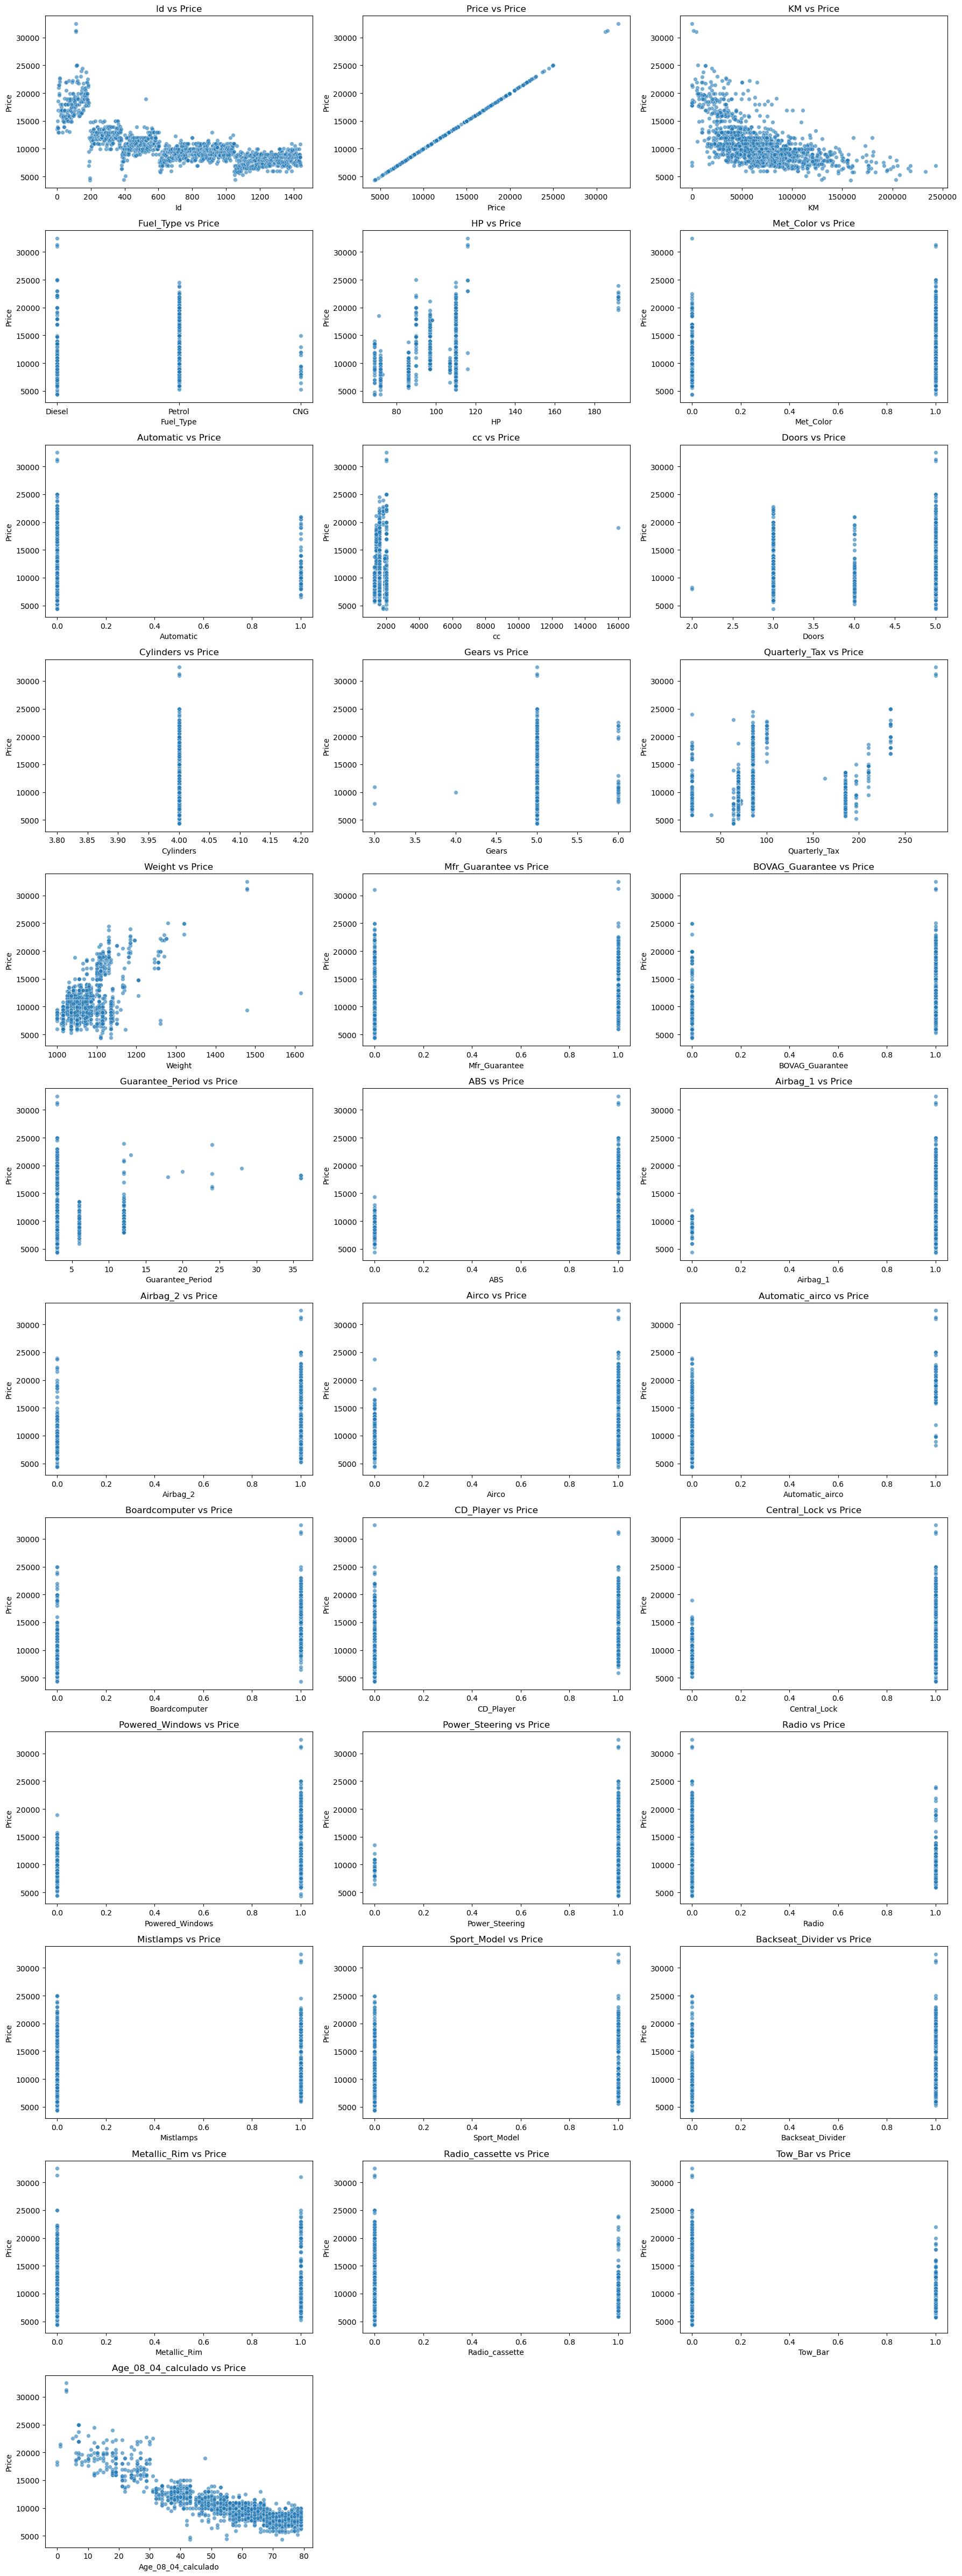

In [15]:
# Dataset limpio que contiene las features y el target "Price"
df_plot = df.copy()
df_plot = df_plot.drop(columns=["Model"])

# Creamos una figura con subplots
n_cols = 3
n_rows = int(len(df_plot.columns) / n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Graficar scatter plot para cada feature contra el precio
for i, col in enumerate(df_plot.columns):
    sns.scatterplot(ax=axes[i], data=df_plot, x=col, y="Price", alpha=0.6, s=30)
    axes[i].set_title(f"{col} vs Price")

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [22]:
def remove_outliers_iqr(df, features, factor=1.5):
    df_clean = df.copy()
    for col in features:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

In [ ]:
features_numericas = df_plot.select_dtypes(include='number').columns
df_clean = remove_outliers_iqr(df_plot, features_numericas, factor=5)

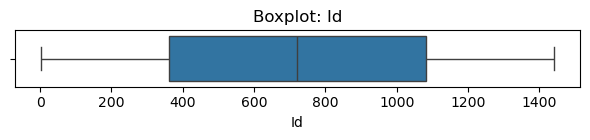

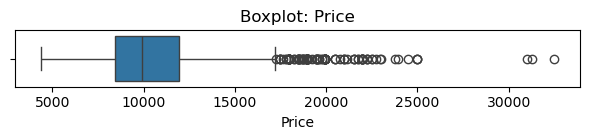

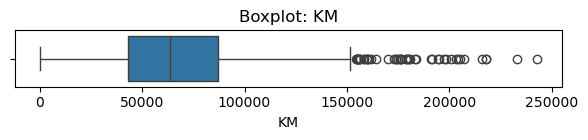

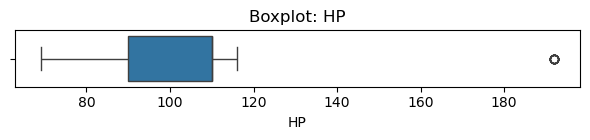

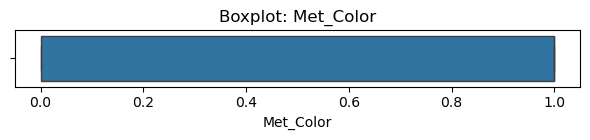

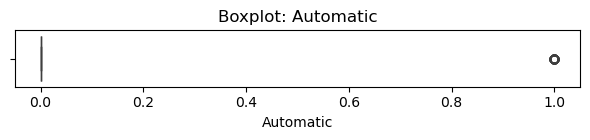

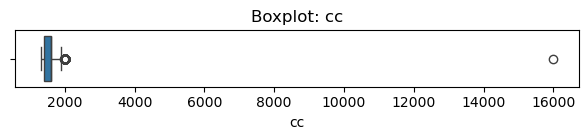

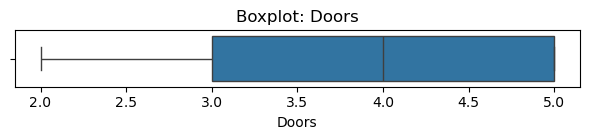

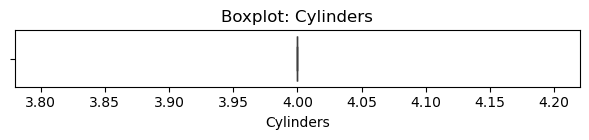

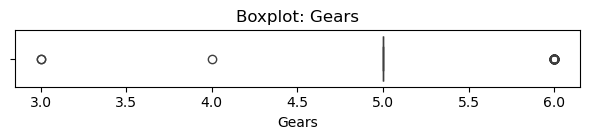

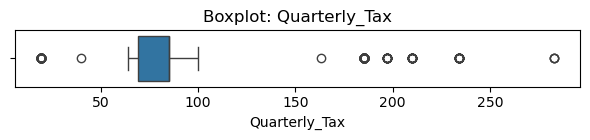

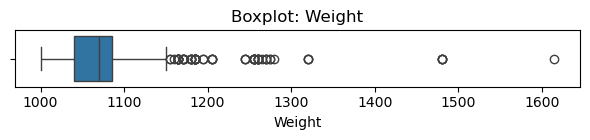

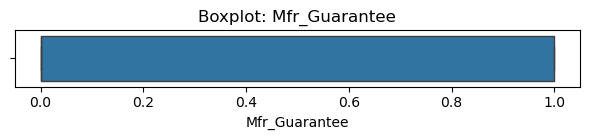

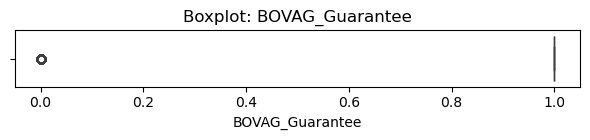

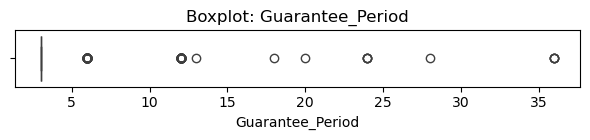

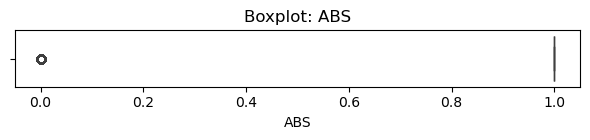

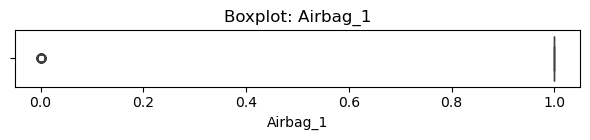

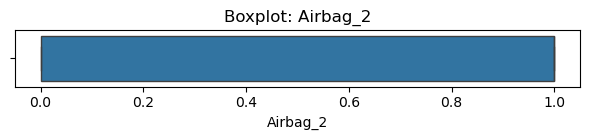

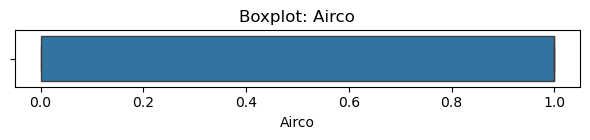

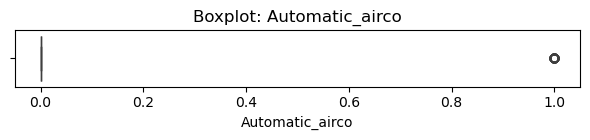

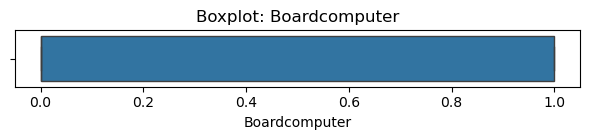

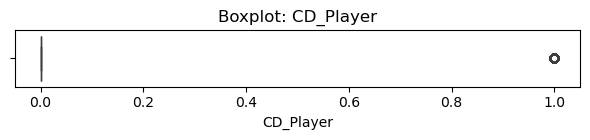

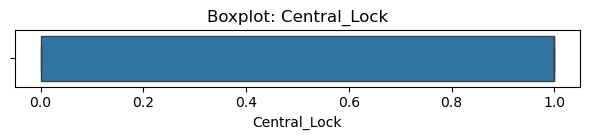

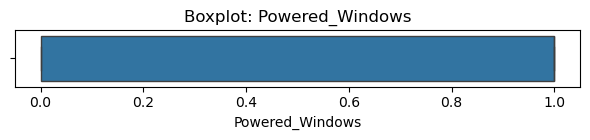

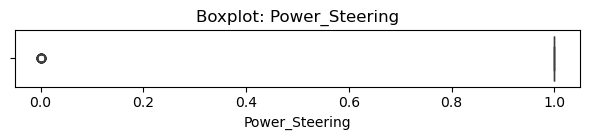

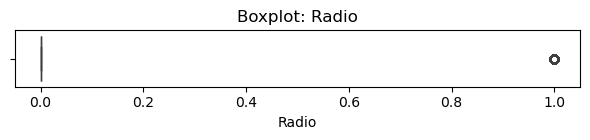

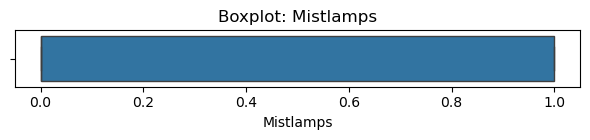

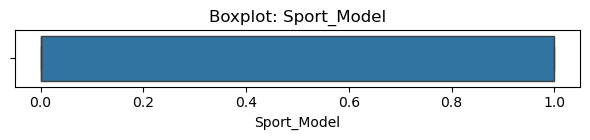

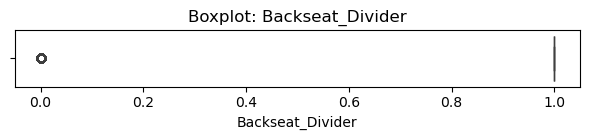

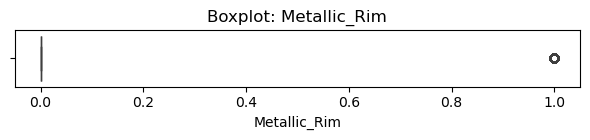

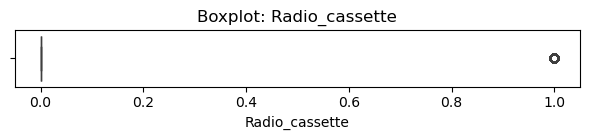

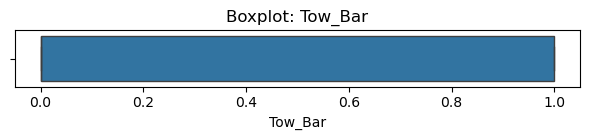

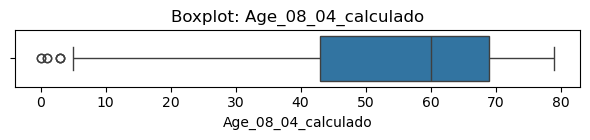

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in features_numericas:
    plt.figure(figsize=(6,1.5))
    sns.boxplot(data=df_plot, x=col)
    plt.title(f"Boxplot: {col}")
    plt.tight_layout()
    plt.show()

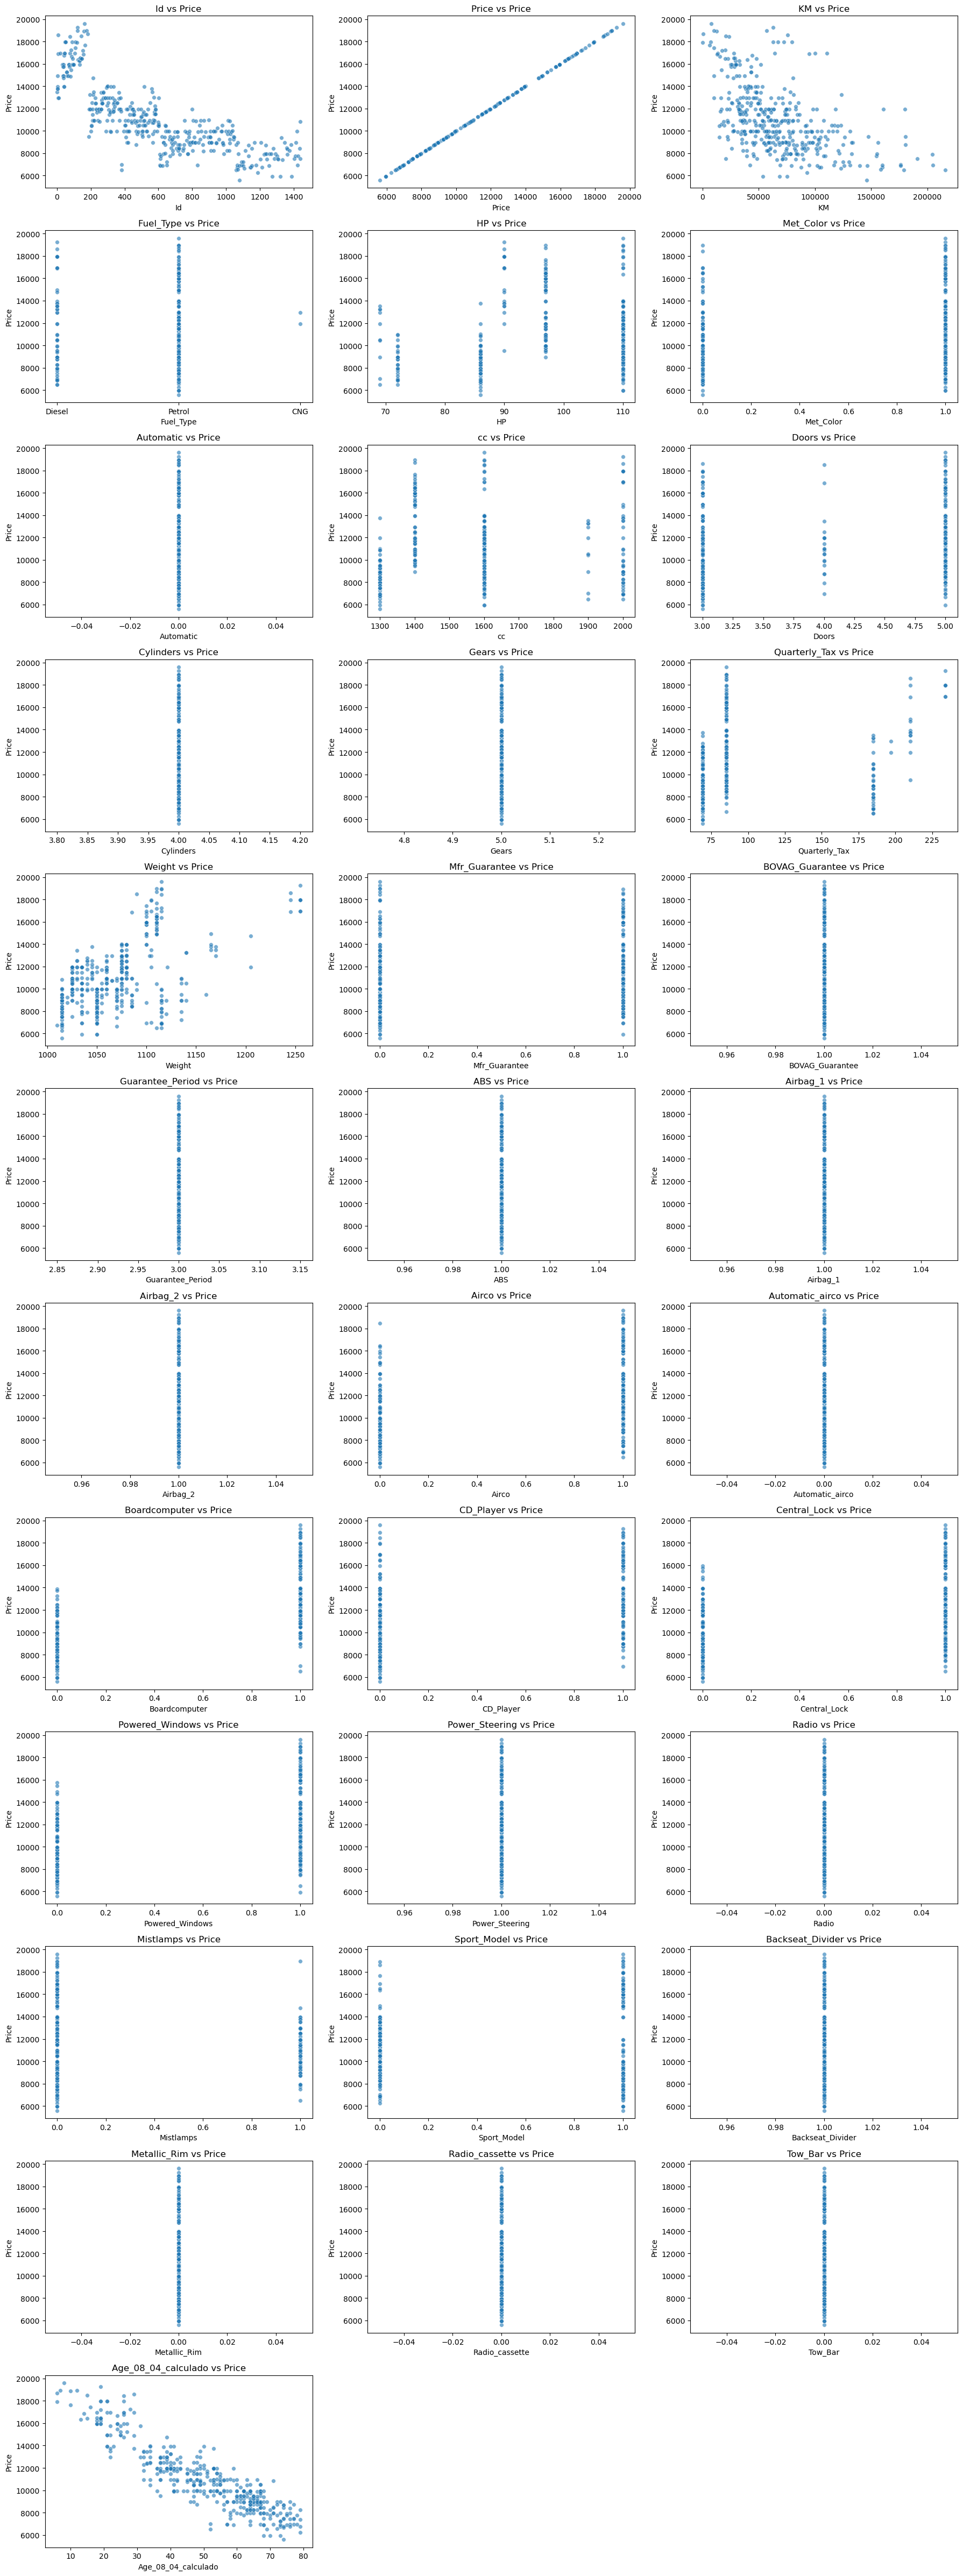

In [33]:
# Creamos una figura con subplots
n_cols = 3
n_rows = int(len(df_clean.columns) / n_cols) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

# Graficar scatter plot para cada feature contra el precio
for i, col in enumerate(df_clean.columns):
    sns.scatterplot(ax=axes[i], data=df_clean, x=col, y="Price", alpha=0.6, s=30)
    axes[i].set_title(f"{col} vs Price")

# Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [35]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Separar features y target
df_ridge = df_clean.copy()

# df_ridge = df_ridge.drop(columns=["Model", "Id"])

X = df_ridge.drop(columns="Price")
y = df_ridge["Price"]

# Preprocesamiento
X = pd.get_dummies(X, drop_first=True)           # One-hot encoding
X = X.apply(pd.to_numeric, errors='coerce')      # Forzar datos a numérico
y = pd.to_numeric(y, errors='coerce')            # Lo mismo para el target

# 2. Escalar las features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

# 4. Ridge con validación cruzada para elegir alpha
alphas = np.logspace(-4, 4, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train, y_train)

# 5. Predicciones
y_train_pred = ridge_cv.predict(X_train)
y_test_pred = ridge_cv.predict(X_test)

# 6. Métricas
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# 7. Resultados
print("Alpha óptimo:", ridge_cv.alpha_)
print("\n--- Entrenamiento ---")
print("MSE:", mse_train)
print("R²:", r2_train)

print("\n--- Test ---")
print("MSE:", mse_test)
print("R²:", r2_test)

# 8. Coeficientes
coeficientes = pd.Series(ridge_cv.coef_, index=X.columns)
print("\nCoeficientes:")
print(coeficientes)


Alpha óptimo: 4.037017258596558

--- Entrenamiento ---
MSE: 795525.5302863481
R²: 0.9030250938367751

--- Test ---
MSE: 971872.2574412371
R²: 0.9042404662632603

Coeficientes:
Id                     -333.743543
KM                     -642.842276
HP                     -154.082251
Met_Color               -25.715958
Automatic                 0.000000
cc                     -125.044753
Doors                   -41.804320
Cylinders                 0.000000
Gears                     0.000000
Quarterly_Tax          -333.101536
Weight                 1293.652164
Mfr_Guarantee           118.501328
BOVAG_Guarantee           0.000000
Guarantee_Period          0.000000
ABS                       0.000000
Airbag_1                  0.000000
Airbag_2                  0.000000
Airco                   144.479968
Automatic_airco           0.000000
Boardcomputer          -246.590847
CD_Player               159.210287
Central_Lock            261.326340
Powered_Windows         -35.636038
Power_Steering     

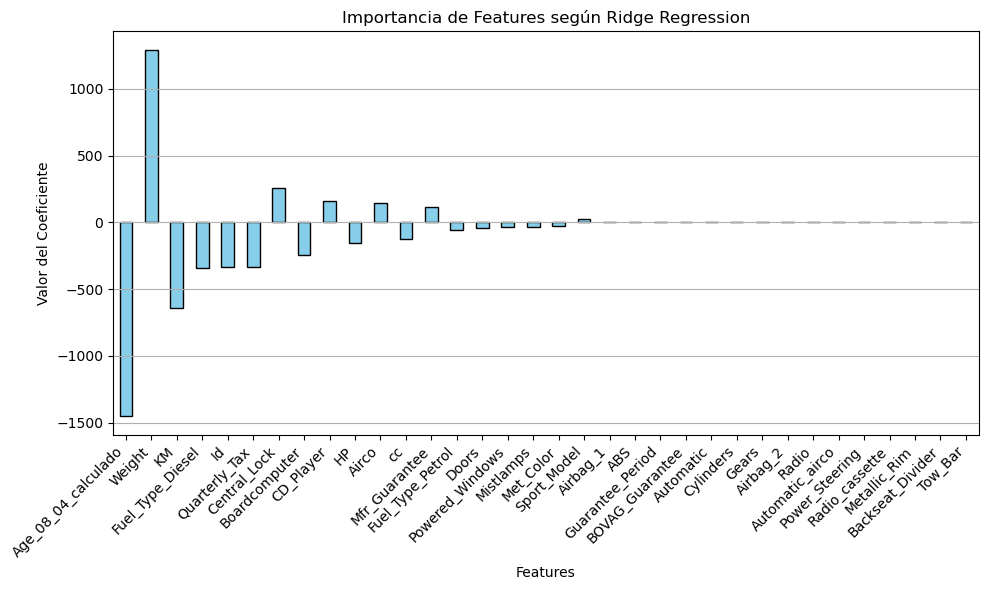

In [36]:
import matplotlib.pyplot as plt

# Ordenar coeficientes por valor absoluto
coef_sort = coeficientes.reindex(coeficientes.abs().sort_values(ascending=False).index)

# Gráfico
plt.figure(figsize=(10, 6))
coef_sort.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Importancia de Features según Ridge Regression")
plt.ylabel("Valor del Coeficiente")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()
